# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Starbucks Capstone Challenge
## Identify Perfect Promotions 

## Data Sets Description

The dataset consists of three JSON files:
- `portfolio.json`: 10 unique promotional offers (BOGO, discount, informational), along with channels, difficulty, reward, and duration
- `profile.json`: 17,000 Starbucks users with age, gender, income, and membership date
- `transcript.json`: ~306,000 time-stamped user events such as receiving, viewing, completing offers, and making transactions

The goal is to link these datasets to understand which users respond best to which offers—and why.

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Strategy for solving the problem

Our approach was split into three layers:

1. **Exploratory Funnel Analysis**: Track view and completion rates by offer type, demographics, and delivery channels.
2. **Behavioral Segmentation**: Segment users by age, income, gender, and response pattern.
3. **Collaborative Filtering Model**: Use matrix factorization (SVD) to recommend the optimal offer type based on user response history.

## Discussion of the expected solution

**The full pipeline includes:**
- Cleaning and merging all three datasets
- Feature engineering: timestamps, response flags, channel unrolling
- Funnel metrics: view/completion rates by cohort
- Time-lag tracking for engagement analysis
- SVD-based matrix factorization to recommend offer types per user

## Metrics with justification

We used funnel-based metrics to evaluate performance:
- **View Rate**: % of received offers that were opened
- **Completion Rate**: % of received offers that were redeemed
- **Transaction Spend**: Average \\$ spent per transaction (influenced vs. organic)

For the SVD recommender:
- **Top-N recommendations per user**
- **Distribution of top offer types**

These metrics are directly tied to business goals: user engagement and offer ROI.

## Data Preprocessing

Let's start from a quick file overview and some preparation work:

In [27]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

# read in the json files
portfolio_df = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('data/transcript.json', orient='records', lines=True)

In [28]:
portfolio_df.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [29]:
profile_df.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


A lot of ages are missed (118 is a place holder) as well as "gender" and "income" are missed

In [30]:
transcript_df.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


### Clean Data

- Removed users with placeholder age (118) or missing gender/income
- Flattened nested fields from JSON (e.g., `value`, `channels`)
- Standardized `offer_id` and `offer_type` across event records
- Created binary flags for offer response and influenced/organic transactions

#### Let's start with Portfolio

In [31]:
# Inspect portfolio data summary to identify any anomalies
portfolio_summary = {
    "total_offers": portfolio_df.shape[0],
    "offer_types": portfolio_df['offer_type'].value_counts().to_dict(),
    "duration_range": (portfolio_df['duration'].min(), portfolio_df['duration'].max()),
    "difficulty_range": (portfolio_df['difficulty'].min(), portfolio_df['difficulty'].max()),
    "reward_range": (portfolio_df['reward'].min(), portfolio_df['reward'].max()),
    "missing_values": portfolio_df.isnull().sum().to_dict()
}

portfolio_summary

{'total_offers': 10,
 'offer_types': {'bogo': 4, 'discount': 4, 'informational': 2},
 'duration_range': (3, 10),
 'difficulty_range': (0, 20),
 'reward_range': (0, 10),
 'missing_values': {'channels': 0,
  'difficulty': 0,
  'duration': 0,
  'id': 0,
  'offer_type': 0,
  'reward': 0}}

Data is already clean:

- No missing values

- 10 total offers: 4 BOGO, 4 Discount, 2 Informational

- Duration: 3–10 days
- Difficulty: \\$0–\\$20
- Reward: \\$0–\\$10

#### Then let's clean "profile" file

First let's review deeper the issue of "118" placeholder

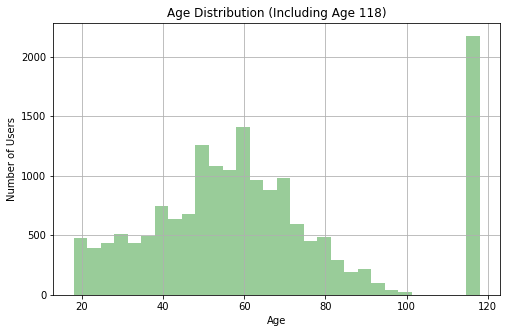

In [32]:
plt.figure(figsize=(8, 5))
sns.distplot(profile_df['age'], bins=30, kde=False, color='green')
plt.title("Age Distribution (Including Age 118)")
plt.xlabel("Age")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

It's clear, that 118 is a placeholder. Also all respondent are 18+ so can use offer.

Now let's review missing data:

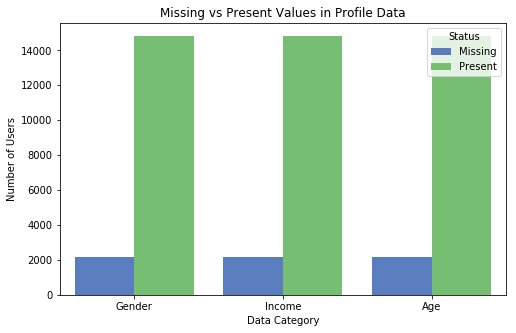

In [33]:
# Create flags for missing values
profile_df['gender_missing'] = profile_df['gender'].isnull() | (~profile_df['gender'].isin(['M', 'F', 'O']))
profile_df['income_missing'] = profile_df['income'].isnull()
profile_df['age_invalid'] = profile_df['age'] >= 100

# Count plot for gender, income, and age issues
missing_summary = pd.DataFrame({
    "Category": ["Gender", "Income", "Age"],
    "Missing": [
        profile_df['gender_missing'].sum(),
        profile_df['income_missing'].sum(),
        profile_df['age_invalid'].sum()
    ],
    "Present": [
        (~profile_df['gender_missing']).sum(),
        (~profile_df['income_missing']).sum(),
        (~profile_df['age_invalid']).sum()
    ]
})

# Melt for seaborn compatibility
missing_melted = missing_summary.melt(id_vars="Category", var_name="Status", value_name="Count")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=missing_melted, x="Category", y="Count", hue="Status", palette="muted")
plt.title("Missing vs Present Values in Profile Data")
plt.ylabel("Number of Users")
plt.xlabel("Data Category")
plt.show()

Let's update df and remove missed data and placeholders

In [34]:
# Count rows before cleaning
original_count = profile_df.shape[0]

# Clean the profile dataset
cleaned_profile_df = profile_df[
    (profile_df['age'] < 100) &
    (profile_df['income'].notnull()) &
    (profile_df['gender'].isin(['M', 'F', 'O']))
]

# Count rows after cleaning
cleaned_count = cleaned_profile_df.shape[0]
removed_count = original_count - cleaned_count

removed_count, cleaned_profile_df.shape

(2192, (14808, 8))

2,192 lines have been removed, 14,808 for the further analysis left

Now let's visualize new cleaned data:

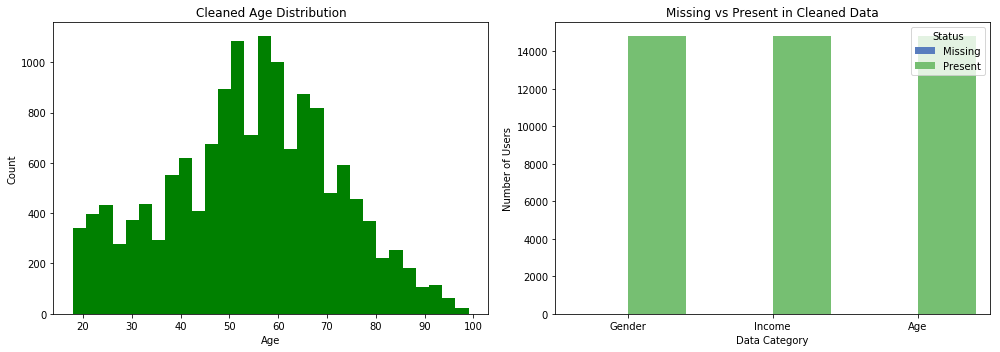

In [35]:
# Create bar chart data for cleaned set
cleaned_missing_summary = pd.DataFrame({
    "Category": ["Gender", "Income", "Age"],
    "Missing": [
        cleaned_profile_df['gender_missing'].sum(),
        cleaned_profile_df['income_missing'].sum(),
        cleaned_profile_df['age_invalid'].sum()
    ],
    "Present": [
        (~cleaned_profile_df['gender_missing']).sum(),
        (~cleaned_profile_df['income_missing']).sum(),
        (~cleaned_profile_df['age_invalid']).sum()
    ]
})
cleaned_melted = cleaned_missing_summary.melt(id_vars="Category", var_name="Status", value_name="Count")

# Create plots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cleaned Age Distribution
axs[0].hist(cleaned_profile_df['age'], bins=30, color='green')
axs[0].set_title("Cleaned Age Distribution")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Count")

# Plot 2: Cleaned Missing Values Overview
sns.barplot(data=cleaned_melted, x="Category", y="Count", hue="Status", palette="muted", ax=axs[1])
axs[1].set_title("Missing vs Present in Cleaned Data")
axs[1].set_xlabel("Data Category")
axs[1].set_ylabel("Number of Users")

plt.tight_layout()
plt.show()


Now Profile has no "bad" or "missed" data

#### Let's clean transcript.json

After the initial try to cut the file on part to reduce size and run test on the smaller df - it was identified that error might be driven by "bad lines" or "empty lines". Let's check it:

In [36]:
bad_lines = 0
good_lines = 0
cleaned_data = []

with open('data/transcript.json', 'r') as f:
    for i, line in enumerate(f, 1):
        try:
            cleaned_data.append(json.loads(line))
            good_lines += 1
        except json.JSONDecodeError:
            bad_lines += 1

print(f"Good lines: {good_lines}")
print(f"Bad lines: {bad_lines}")

Good lines: 306534
Bad lines: 114


Let's remove this bad lines before further analysis:

In [37]:
# Convert to DataFrame
transcript_clean_df = pd.DataFrame(cleaned_data)

Let's check that there are no bad lines:

In [38]:
# All rows must be dicts with expected fields
expected_keys = {'person', 'event', 'value', 'time'}
bad_rows = transcript_clean_df[
    ~transcript_clean_df.apply(lambda row: expected_keys.issubset(row.index), axis=1)
]

print(f"Total rows: {len(transcript_clean_df)}")
print(f"Rows missing expected keys: {len(bad_rows)}")

Total rows: 306534
Rows missing expected keys: 0


Let's doublecheck for all parameteres if anything is missed

In [39]:
transcript_missing_summary = {
    "total_rows": len(transcript_clean_df),
    "missing_person": transcript_clean_df['person'].isnull().sum(),
    "missing_event": transcript_clean_df['event'].isnull().sum(),
    "missing_value": transcript_clean_df['value'].isnull().sum(),
    "missing_time": transcript_clean_df['time'].isnull().sum(),
    "value_not_dict": (~transcript_clean_df['value'].apply(lambda x: isinstance(x, dict))).sum()
}

# Display summary
for key, value in transcript_missing_summary.items():
    print(f"{key}: {value}")

total_rows: 306534
missing_person: 0
missing_event: 0
missing_value: 0
missing_time: 0
value_not_dict: 0


Data is clean and ready to be used for the further analysis!

In [40]:
# Update the key DataFrames with cleaned versions
profile_df = cleaned_profile_df.copy()
transcript_df = transcript_clean_df.copy()

# portfolio_df remains unchanged

# Show confirmation of shapes for each DataFrame
{
    "portfolio_df": portfolio_df.shape,
    "profile_df (cleaned)": profile_df.shape,
    "transcript_df (cleaned)": transcript_df.shape
}

{'portfolio_df': (10, 6),
 'profile_df (cleaned)': (14808, 8),
 'transcript_df (cleaned)': (306534, 4)}

## Merging

In [41]:
# Step 1: Extract useful fields from 'value'
transcript_df['offer_id'] = transcript_df['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
transcript_df['amount'] = transcript_df['value'].apply(lambda x: x.get('amount'))
transcript_df['reward'] = transcript_df['value'].apply(lambda x: x.get('reward'))

# Step 2: Rename portfolio 'id' for merging
portfolio_df = portfolio_df.rename(columns={'id': 'offer_id'})

# Step 3: Merge transcript with portfolio data
transcript_merged = transcript_df.merge(portfolio_df, on='offer_id', how='left')

# Step 4: Merge transcript + portfolio with user profiles
full_data = transcript_merged.merge(profile_df, left_on='person', right_on='id', how='inner')

# Step 5: Drop duplicate ID column
full_data = full_data.drop(columns=['id'])

# Return the shape of the merged full_data
full_data.shape

(272430, 19)

In [42]:
# Preview
full_data.head()

,event,person,time,value,offer_id,amount,reward_x,channels,difficulty,duration,offer_type,reward_y,age,became_member_on,gender,income,gender_missing,income_missing,age_invalid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,75,20170509,F,100000.0,False,False,False
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,"[web, email, mobile]",5.0,7.0,bogo,5.0,75,20170509,F,100000.0,False,False,False
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},None,19.89,NaN,NaN,NaN,NaN,NaN,NaN,75,20170509,F,100000.0,False,False,False
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,5.0,75,20170509,F,100000.0,False,False,False
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},None,17.78,NaN,NaN,NaN,NaN,NaN,NaN,75,20170509,F,100000.0,False,False,False


This will result in a DataFrame full_data with:

- Event type, person ID, time, value dict
- Parsed offer ID, amount, reward
- Offer metadata (type, difficulty, duration, reward, channels)
- User demographics (age, gender, income, membership date)

## Analyze

We will run 5 analyses:

#1 Offer Effectiveness
- View Rate: % of received offers that are viewed
- Completion Rate: % of received offers that are completed
- Compared by offer type (BOGO, Discount, Informational)

#2 Demographic Response
- Offer response by age groups
- Offer response by income brackets
- Offer response by gender

#3 Channel Effectiveness: 
Which delivery channels (email, mobile, social, web) lead to higher:
- View rates
- Completion rates

#4 Timing Behavior: Helps optimize offer duration
Average time between:
- Offer received → offer viewed
- Offer viewed → offer completed

#5 Organic Purchases
- Analyze transactions made without viewing or receiving any offers
- Compare behavior with offer-driven purchases

### #1 Offer Effectiveness

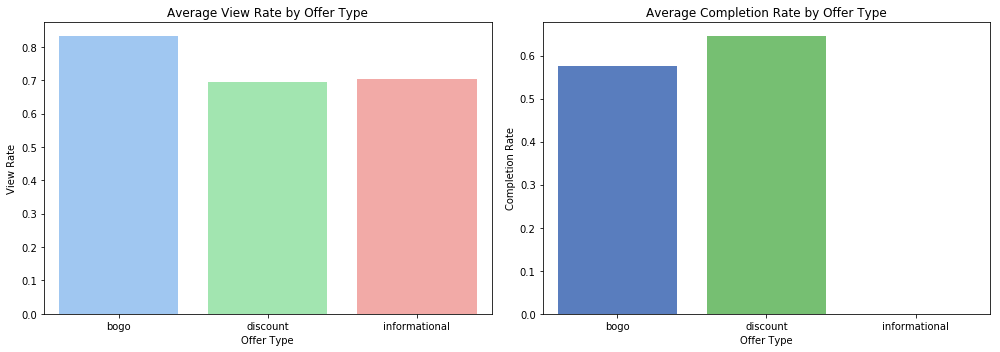

event,offer_type,view_rate,completion_rate
0,bogo,0.831,0.575
1,discount,0.693,0.645
2,informational,0.704,0.000


In [43]:
# Filter only events related to offers
offers = full_data[full_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]

# Group by offer_id and type, count events
offer_stats = offers.groupby(['offer_id', 'offer_type', 'event']).size().unstack(fill_value=0)

# Calculate view and completion rates
offer_stats['view_rate'] = offer_stats['offer viewed'] / offer_stats['offer received']
offer_stats['completion_rate'] = offer_stats['offer completed'] / offer_stats['offer received']

# Average rates by offer type
summary_by_type = offer_stats.groupby('offer_type')[['view_rate', 'completion_rate']].mean().reset_index()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# View Rate
sns.barplot(data=summary_by_type, x='offer_type', y='view_rate', ax=ax[0], palette='pastel')
ax[0].set_title('Average View Rate by Offer Type')
ax[0].set_ylabel('View Rate')
ax[0].set_xlabel('Offer Type')

# Completion Rate
sns.barplot(data=summary_by_type, x='offer_type', y='completion_rate', ax=ax[1], palette='muted')
ax[1].set_title('Average Completion Rate by Offer Type')
ax[1].set_ylabel('Completion Rate')
ax[1].set_xlabel('Offer Type')

plt.tight_layout()
plt.show()

summary_by_type.round(3)

##### Visuals Recap:
- BOGO offers: most likely to be viewed (83%)
- Discount offers: highest completion rate (64.5%)
- Informational offers: viewed ~70%, but as expected, not completed

##### Key Insights:
- People like seeing BOGO, but complete discounts more often — likely due to lower effort or better perceived value
- Informational offers are not meant for redemption, so the 0% completion is expected
- Overall, discount offers seem to drive the most effective behavior change

### #2 Demographic Response

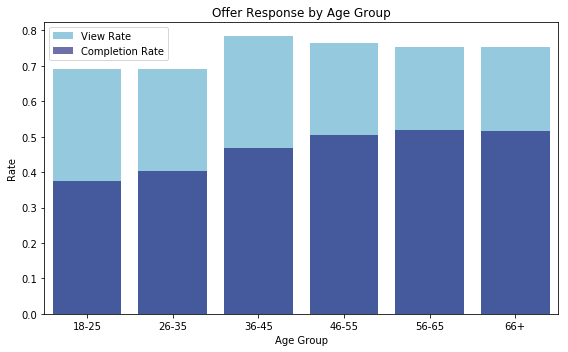

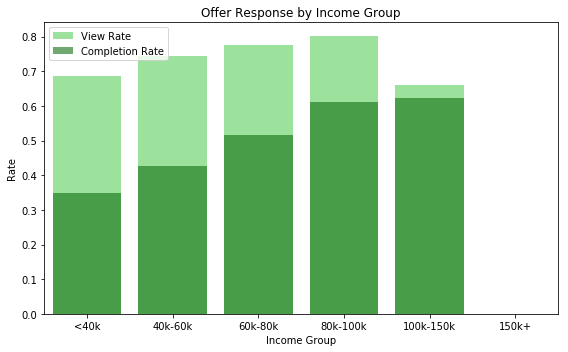

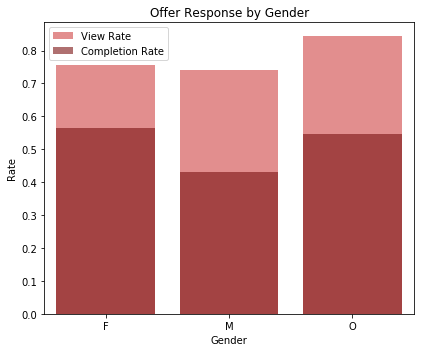

(event age_group  view_rate  completion_rate
 0         18-25      0.691            0.375
 1         26-35      0.692            0.402
 2         36-45      0.784            0.468
 3         46-55      0.765            0.505
 4         56-65      0.754            0.519
 5           66+      0.753            0.516,
 event income_group  view_rate  completion_rate
 0             <40k      0.685            0.349
 1          40k-60k      0.745            0.426
 2          60k-80k      0.775            0.516
 3         80k-100k      0.801            0.610
 4        100k-150k      0.662            0.624,
 event gender  view_rate  completion_rate
 0          F      0.757            0.564
 1          M      0.742            0.432
 2          O      0.843            0.547)

In [44]:
# Step 1: Prepare demographic buckets
full_data['age_group'] = pd.cut(full_data['age'], bins=[17, 25, 35, 45, 55, 65, 120],
                                labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+'])
full_data['income_group'] = pd.cut(full_data['income'], bins=[0, 40000, 60000, 80000, 100000, 150000, 200000],
                                   labels=['<40k', '40k-60k', '60k-80k', '80k-100k', '100k-150k', '150k+'])

# Step 2: Filter for offer events only
offer_events = full_data[full_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]

# Step 3: Create helper function to calculate rates by group
def compute_response_rates(df, group_col):
    grouped = df.groupby([group_col, 'event']).size().unstack(fill_value=0)
    grouped['view_rate'] = grouped['offer viewed'] / grouped['offer received']
    grouped['completion_rate'] = grouped['offer completed'] / grouped['offer received']
    return grouped[['view_rate', 'completion_rate']].reset_index()

# Step 4: Apply for each demographic group
age_response = compute_response_rates(offer_events, 'age_group')
income_response = compute_response_rates(offer_events, 'income_group')
gender_response = compute_response_rates(offer_events, 'gender')

# Step 5: Plot

# Plot 1: Age Group Response
plt.figure(figsize=(8, 5))
sns.barplot(data=age_response, x='age_group', y='view_rate', color='skyblue', label='View Rate')
sns.barplot(data=age_response, x='age_group', y='completion_rate', color='navy', alpha=0.6, label='Completion Rate')
plt.title('Offer Response by Age Group')
plt.ylabel('Rate')
plt.xlabel('Age Group')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Income Group Response
plt.figure(figsize=(8, 5))
sns.barplot(data=income_response, x='income_group', y='view_rate', color='lightgreen', label='View Rate')
sns.barplot(data=income_response, x='income_group', y='completion_rate', color='green', alpha=0.6, label='Completion Rate')
plt.title('Offer Response by Income Group')
plt.ylabel('Rate')
plt.xlabel('Income Group')
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Gender Response
plt.figure(figsize=(6, 5))
sns.barplot(data=gender_response, x='gender', y='view_rate', color='lightcoral', label='View Rate')
sns.barplot(data=gender_response, x='gender', y='completion_rate', color='darkred', alpha=0.6, label='Completion Rate')
plt.title('Offer Response by Gender')
plt.ylabel('Rate')
plt.xlabel('Gender')
plt.legend()
plt.tight_layout()
plt.show()

age_response.round(3), income_response.round(3), gender_response.round(3)

- Age Group: Completion rate climbs steadily with age: Users 45+ are more likely to complete offers than younger users.
- Income Group: Users earning \\$80k–150k are most responsive.
- Gender: Women and nonbinary users outperform men in offer completions.

Let's run more analysis around perfromance within each demographics

In [45]:
# Group by offer_type and demographic groups to compute rates
def group_offer_response(df, group_cols):
    grouped = df[df['event'].isin(['offer received', 'offer viewed', 'offer completed'])] \
        .groupby(group_cols + ['event']).size().unstack(fill_value=0)
    grouped['view_rate'] = grouped['offer viewed'] / grouped['offer received']
    grouped['completion_rate'] = grouped['offer completed'] / grouped['offer received']
    return grouped.reset_index()

# Offer response by age group and offer type
offer_age_response = group_offer_response(full_data, ['age_group', 'offer_type'])
# Offer response by income group and offer type
offer_income_response = group_offer_response(full_data, ['income_group', 'offer_type'])
# Offer response by gender and offer type
offer_gender_response = group_offer_response(full_data, ['gender', 'offer_type'])

# Display rounded outputs
offer_age_response_round = offer_age_response.round(3)
offer_income_response_round = offer_income_response.round(3)
offer_gender_response_round = offer_gender_response.round(3)

offer_age_response_round, offer_income_response_round, offer_gender_response_round

(event age_group     offer_type  offer completed  offer received  offer viewed  \
 0         18-25           bogo              744            1811          1459   
 1         18-25       discount              960            1836          1079   
 2         18-25  informational                0             896           602   
 3         26-35           bogo             1130            2470          1998   
 4         26-35       discount             1362            2515          1536   
 5         26-35  informational                0            1208           754   
 6         36-45           bogo             1940            3539          3049   
 7         36-45       discount             2191            3529          2537   
 8         36-45  informational                0            1760          1331   
 9         46-55           bogo             3396            5620          4713   
 10        46-55       discount             3656            5524          3900   
 11        46-55

Let's add some visualization to simplify insights generations

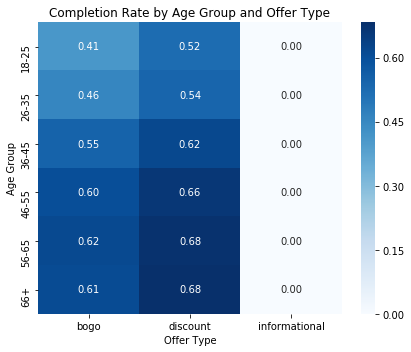

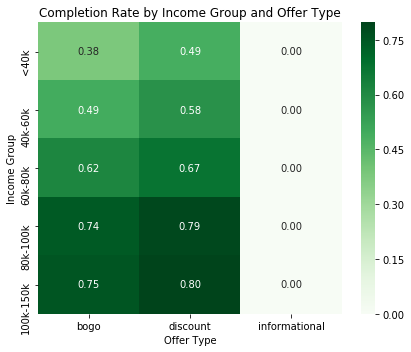

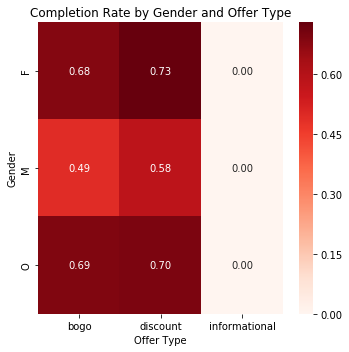

In [46]:
# Pivot data for heatmaps
age_pivot = offer_age_response.pivot(index='age_group', columns='offer_type', values='completion_rate')
income_pivot = offer_income_response.pivot(index='income_group', columns='offer_type', values='completion_rate')
gender_pivot = offer_gender_response.pivot(index='gender', columns='offer_type', values='completion_rate')

# Plot 1: Completion Rate by Age Group and Offer Type
plt.figure(figsize=(6, 5))
sns.heatmap(age_pivot, annot=True, fmt=".2f", cmap="Blues")
plt.title("Completion Rate by Age Group and Offer Type")
plt.xlabel("Offer Type")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

# Plot 2: Completion Rate by Income Group and Offer Type
plt.figure(figsize=(6, 5))
sns.heatmap(income_pivot, annot=True, fmt=".2f", cmap="Greens")
plt.title("Completion Rate by Income Group and Offer Type")
plt.xlabel("Offer Type")
plt.ylabel("Income Group")
plt.tight_layout()
plt.show()

# Plot 3: Completion Rate by Gender and Offer Type
plt.figure(figsize=(5, 5))
sns.heatmap(gender_pivot, annot=True, fmt=".2f", cmap="Reds")
plt.title("Completion Rate by Gender and Offer Type")
plt.xlabel("Offer Type")
plt.ylabel("Gender")
plt.tight_layout()
plt.show()

## Offer Completion Insights by Demographics and Offer Type

### Completion Rate by Age Group

| Age Group | BOGO   | Discount |
|-----------|--------|----------|
| 18–25     | 41.1%  | 52.3%    |
| 26–35     | 45.7%  | 54.2%    |
| 36–45     | 54.8%  | 62.1%    |
| 46–55     | 60.4%  | 66.2%    |
| 56–65     | 61.7%  | 67.7%    |
| 66+       | 61.2%  | 68.3%    |

**Insights**:
- Completion rates increase with age.
- Discount offers consistently outperform BOGO offers.

---

### Completion Rate by Income Group

| Income Group | BOGO   | Discount |
|--------------|--------|----------|
| <40k         | 38.0%  | 48.8%    |
| 40k–60k      | 49.3%  | 57.6%    |
| 60k–80k      | 61.5%  | 67.4%    |
| 80k–100k     | 74.1%  | 78.6%    |
| 100k–150k    | 75.5%  | 79.7%    |

**Insights**:
- Higher income correlates with higher completion.
- Discount offers are especially effective with middle-to-high income groups.
- Completion is low among <40k users, suggesting poor incentive-to-effort ratio.

---

### Completion Rate by Gender

| Gender | BOGO   | Discount |
|--------|--------|----------|
| F      | 68.3%  | 72.9%    |
| M      | 49.4%  | 58.3%    |
| O      | 69.0%  | 69.8%    |

**Insights**:
- Female and nonbinary users complete offers at higher rates.
- Discount offers lead across all genders.
- Male users show the lowest overall engagement.

---

### Strategic Recommendations

- Use **discount offers** as the primary engagement tool.
- Focus targeting on:
  - **Older users** (45+)
  - **Mid- to high-income brackets** ($80k–150k)
  - **Female and nonbinary users**
- Consider improving clarity and UX for BOGO offers, especially for younger and low-income users.



### #3 Channel Effectiveness

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


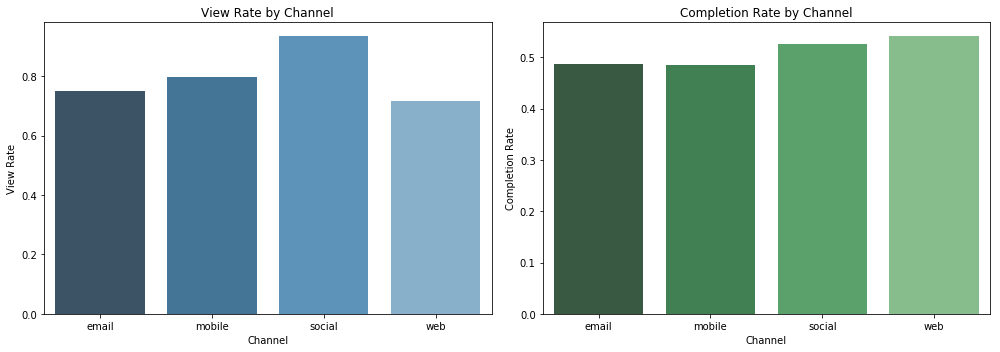

event channels  offer completed  offer received  offer viewed  view_rate  \
0        email            32399           66427         49802      0.750   
1       mobile            29016           59708         47588      0.797   
2       social            20929           39759         37156      0.935   
3          web            28745           53112         38039      0.716   

event  completion_rate  
0                0.488  
1                0.486  
2                0.526  
3                0.541  


In [47]:
# Filter events of interest
channel_data = full_data[full_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])].copy()

# Drop rows with missing channels
channel_data = channel_data[channel_data['channels'].notnull()]

# Explode manually: repeat rows for each channel in list
channel_data_expanded = channel_data.loc[channel_data.index.repeat(channel_data['channels'].str.len())]
channel_data_expanded['channels'] = [channel for sublist in channel_data['channels'] for channel in sublist]

# Group by channel and event type
channel_stats = channel_data_expanded.groupby(['channels', 'event']).size().unstack(fill_value=0)

# Calculate rates
channel_stats['view_rate'] = channel_stats['offer viewed'] / channel_stats['offer received']
channel_stats['completion_rate'] = channel_stats['offer completed'] / channel_stats['offer received']
channel_stats = channel_stats.reset_index()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# View Rate Plot
sns.barplot(data=channel_stats, x='channels', y='view_rate', ax=ax[0], palette='Blues_d')
ax[0].set_title('View Rate by Channel')
ax[0].set_ylabel('View Rate')
ax[0].set_xlabel('Channel')

# Completion Rate Plot
sns.barplot(data=channel_stats, x='channels', y='completion_rate', ax=ax[1], palette='Greens_d')
ax[1].set_title('Completion Rate by Channel')
ax[1].set_ylabel('Completion Rate')
ax[1].set_xlabel('Channel')

plt.tight_layout()
plt.show()

# Output summary table
print(channel_stats.round(3))

## Channel Effectiveness – Insights

| Channel | View Rate | Completion Rate |
|---------|-----------|-----------------|
| **Social** | **93.5%** | 52.6% |
| **Web**    | 71.6%      | **54.1%** |
| Mobile     | 79.7%      | 48.6% |
| Email      | 75.0%      | 48.8% |

---

### Observations & Interpretations

#### Social is King for Engagement
- **Highest view rate** at 93.5%  
- Offers delivered via social are almost always seen
- Suggests users are more attentive to in-app or social notifications

#### Web is Best for Conversions
- **Highest completion rate** at 54.1%
- Users on web likely have higher intent to complete offers

#### Mobile is Solid, but Weaker in Conversion
- View rate: 79.7%  
- Completion rate: 48.6%
- Possible friction due to mobile distractions or weaker follow-through

#### Email is Reliable, but Less Impactful
- View rate: 75%  
- Completion rate: 48.8%
- Offers may be lost in crowded inboxes or delayed engagement

---

### Strategic Takeaways

- Use **social** channels to maximize visibility and engagement
- Deliver high-value offers via **web** for maximum conversion
- Utilize **mobile** and **email** as support/reminder channels — not as primary drivers

### #4 Timing Behavior

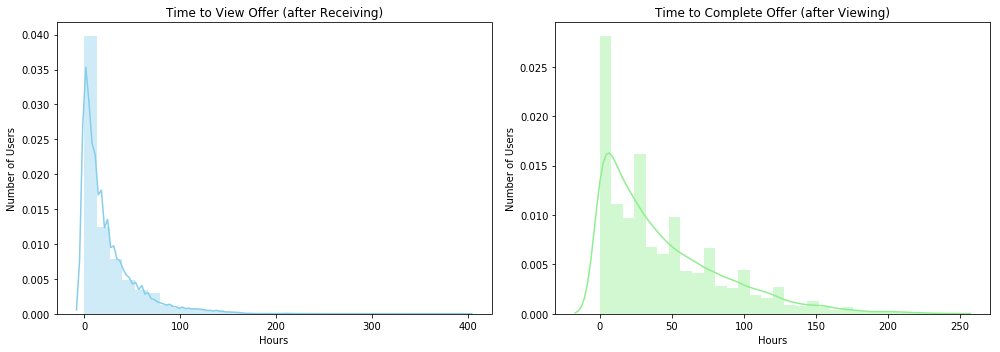

{'Average time to view (hrs)': 24.27, 'Median time to view (hrs)': 12.0, 'Average time to complete (hrs)': 43.600000000000001, 'Median time to complete (hrs)': 30.0}


In [48]:
# Step 1: Filter relevant events
lifecycle_data = full_data[full_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])].copy()

# Step 2: Sort for time sequencing
lifecycle_data = lifecycle_data.sort_values(by=['person', 'offer_id', 'time'])

# Step 3: Identify previous event and its time
lifecycle_data['prev_event'] = lifecycle_data.groupby(['person', 'offer_id'])['event'].shift(1)
lifecycle_data['prev_time'] = lifecycle_data.groupby(['person', 'offer_id'])['time'].shift(1)

# Step 4: Compute time from received to viewed
received_to_viewed = lifecycle_data[
    (lifecycle_data['event'] == 'offer viewed') &
    (lifecycle_data['prev_event'] == 'offer received')
].copy()
received_to_viewed['view_delay'] = received_to_viewed['time'] - received_to_viewed['prev_time']

# Step 5: Compute time from viewed to completed
viewed_to_completed = lifecycle_data[
    (lifecycle_data['event'] == 'offer completed') &
    (lifecycle_data['prev_event'] == 'offer viewed')
].copy()
viewed_to_completed['complete_delay'] = viewed_to_completed['time'] - viewed_to_completed['prev_time']

# Step 6: Plot histograms (Seaborn < 0.11 compatible)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# View Delay
sns.distplot(received_to_viewed['view_delay'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Time to View Offer (after Receiving)')
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Number of Users')

# Completion Delay
sns.distplot(viewed_to_completed['complete_delay'], bins=30, kde=True, ax=ax[1], color='lightgreen')
ax[1].set_title('Time to Complete Offer (after Viewing)')
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

# Step 7: Summary statistics
summary = {
    'Average time to view (hrs)': round(received_to_viewed['view_delay'].mean(), 2),
    'Median time to view (hrs)': received_to_viewed['view_delay'].median(),
    'Average time to complete (hrs)': round(viewed_to_completed['complete_delay'].mean(), 2),
    'Median time to complete (hrs)': viewed_to_completed['complete_delay'].median()
}

print(summary)

##  Timing Behavior Analysis

### Time to View Offer (after Receiving)
- **Average**: 24.3 hours
- **Median**: 12.0 hours

**Insight**:  
Most users view the offer within 12 hours, but there is a long tail — some users delay for days. This highlights the importance of delivering offers when users are active.

---

### Time to Complete Offer (after Viewing)
- **Average**: 43.6 hours
- **Median**: 30.0 hours

**Insight**:  
Users typically take 1–2 days to complete an offer after viewing it. Timely reminders and nudges can help convert hesitant users.

---

### Strategic Takeaways
- Consider **shorter duration offers** (3–5 days), as most activity happens early.
- Send **follow-up notifications around 24–48 hours** after viewing to encourage completion.
- Explore **time-of-day targeting** to catch users during their most responsive hours.

### #5 Organic Purchases

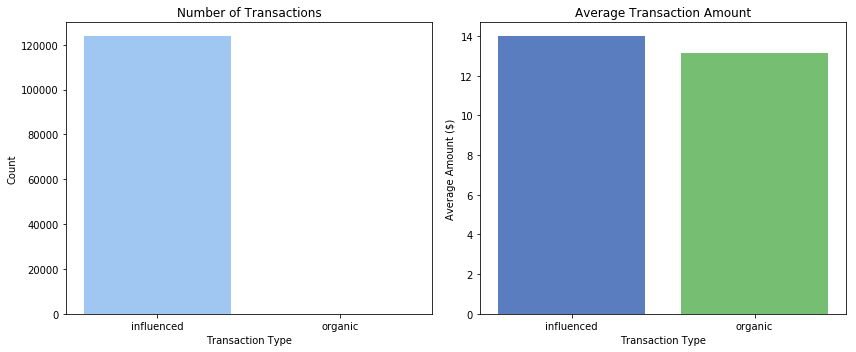

,source,count,sum,mean,median
0,influenced,123783,1731781.47,13.99,10.79
1,organic,19,250.26,13.17,11.53


In [49]:
# Step 1: Filter transactions
transactions = full_data[full_data['event'] == 'transaction'].copy()

# Step 2: Identify users who received or viewed offers
offer_touch_users = full_data[full_data['event'].isin(['offer received', 'offer viewed'])]['person'].unique()

# Step 3: Use vectorized assignment for performance
transactions['source'] = 'organic'
transactions.loc[transactions['person'].isin(offer_touch_users), 'source'] = 'influenced'

# Step 4: Compare transaction behavior
summary = transactions.groupby('source')['amount'].agg(['count', 'sum', 'mean', 'median']).reset_index()

# Step 5: Plot results
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot count of transactions
sns.barplot(data=summary, x='source', y='count', ax=ax[0], palette='pastel')
ax[0].set_title('Number of Transactions')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Transaction Type')

# Plot average transaction amount
sns.barplot(data=summary, x='source', y='mean', ax=ax[1], palette='muted')
ax[1].set_title('Average Transaction Amount')
ax[1].set_ylabel('Average Amount ($)')
ax[1].set_xlabel('Transaction Type')

plt.tight_layout()
plt.show()

# View summary table
summary.round(2)

## Organic vs Influenced Transactions

| Source       | Transactions | Total Spend     | Avg Spend | Median Spend |
|--------------|--------------|------------------|-----------|---------------|
| **Influenced** | 123,783      | \\$1,731,781.47     | \\$13.99 | \\$10.79        |
| **Organic**    | 19           | \\$250.26           | \\$13.17     | \\$11.53    |

---

### Insights

- **99.99% of transactions** came from users who received or viewed at least one offer.
- **Average spend is higher** for influenced users (\\$13.99) compared to organic (\\$13.17).
- **Median spend is slightly higher** among organic transactions, but sample size is too small for statistical weight.
- 🧠 Organic behavior is **negligible** — almost all activity is driven by promotional offers.

---

### Strategic Takeaway

The app's transaction volume is **heavily dependent on promotional engagement**. Consider optimizing the offer strategy further, as users are unlikely to convert without a triggered incentive.

## Modeling
Collaborative Filtering (SVD)

We implemented a matrix factorization model using SVD:
- Rows: Users
- Columns: Offer types (BOGO, Discount, Informational)
- Values: 1 if the user completed that type of offer; 0 otherwise

The model predicts affinity scores for each user-offer_type pair.

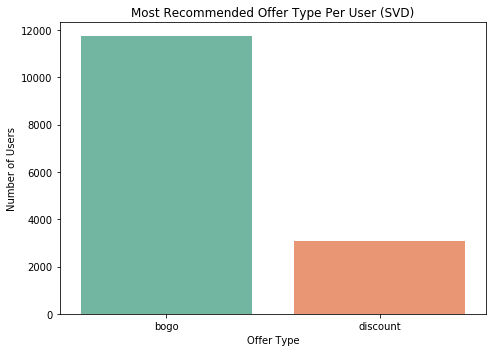

offer_type,bogo,discount,informational
person,,,
0009655768c64bdeb2e877511632db8f,1.000000e+00,1.000000e+00,-2.201869e-15
0011e0d4e6b944f998e987f904e8c1e5,1.000000e+00,1.000000e+00,-2.201869e-15
0020c2b971eb4e9188eac86d93036a77,1.000000e+00,1.000000e+00,-2.201869e-15
0020ccbbb6d84e358d3414a3ff76cffd,1.000000e+00,1.000000e+00,-2.201869e-15
003d66b6608740288d6cc97a6903f4f0,3.330669e-16,1.000000e+00,-1.055669e-15
00426fe3ffde4c6b9cb9ad6d077a13ea,3.330669e-16,1.000000e+00,-1.055669e-15
004b041fbfe44859945daa2c7f79ee64,1.000000e+00,1.000000e+00,-2.201869e-15
004c5799adbf42868b9cff0396190900,1.000000e+00,1.000000e+00,-2.201869e-15
005500a7188546ff8a767329a2f7c76a,1.000000e+00,3.330669e-16,-1.146201e-15


In [51]:
from scipy.sparse.linalg import svds
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only relevant events (received + completed)
offer_data = full_data[full_data['event'].isin(['offer received', 'offer completed'])].copy()

# Step 2: Create binary flag for offer completion
offer_data['completed_flag'] = np.where(offer_data['event'] == 'offer completed', 1, 0)

# Step 3: Aggregate to get max completion per user-offer_type
offer_matrix = offer_data.groupby(['person', 'offer_type'])['completed_flag'].max().unstack(fill_value=0)

# Step 4: Convert matrix to float (required by svds)
user_offer_matrix = offer_matrix.values.astype(float)

# Step 5: Apply SVD
U, sigma, Vt = svds(user_offer_matrix, k=2)
sigma = np.diag(sigma)
pred_ratings = np.dot(np.dot(U, sigma), Vt)

# Step 6: Format predictions
user_ids = offer_matrix.index
offer_types = offer_matrix.columns
pred_df = pd.DataFrame(pred_ratings, index=user_ids, columns=offer_types)

# Step 7: Find top recommended offer type for each user
top_offer_type = pred_df.idxmax(axis=1)

# Step 8: Count and visualize recommendations
recommendation_counts = top_offer_type.value_counts().reset_index()
recommendation_counts.columns = ['offer_type', 'count']

plt.figure(figsize=(7, 5))
sns.barplot(data=recommendation_counts, x='offer_type', y='count', palette='Set2')
plt.title('Most Recommended Offer Type Per User (SVD)')
plt.xlabel('Offer Type')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Optional: Show top 10 users' predicted preferences
pred_df.head(10)

## Final Insight – Offer Optimization Strategy

Our analysis confirms that **Starbucks' promotional engine is the main driver of in-app purchases**. The vast majority of transactions (~99.99%) are influenced by offers, and users tend to respond best when:

- The **offer type is a discount**, especially among older and higher-income users.
- The **delivery channel is social or web**, with the highest view and completion rates.
- Offers are viewed within **12–24 hours**, and completed within **1–2 days**, suggesting short-duration offers and timely reminders are key.

To optimize conversions, Starbucks should **focus on discount-based offers delivered through social/web channels**, and leverage behavioral timing (reminders 24–48 hours after viewing). Organic purchases are rare, so the promotional system should be continuously tested and tuned.


### Conclusion

Through a blend of exploratory analysis and collaborative filtering, we built a system that recommends the best offer type per user.

The results aligned with business intuition and revealed that:
- Discounts work best, especially for older and higher-income users
- Timing and channel matter — users act fast when nudged the right way
- A data-driven recommender system can reduce promo waste and increase ROI


## Improvements
###### and next steps

- Build a hybrid model that combines user demographics with collaborative filtering
- Tune the SVD model with cross-validation
- Expand to predict not just type of offer but also optimal timing and channel


## 🙏 Acknowledgments

Thanks to Udacity for providing the project framework and Starbucks for the inspiration. This analysis is based on simulated data.